# ResNet18 Deformable Convolutions

This section explores replacing standard convolutions within the residual blocks with deformable convolutions and evaluates the effect on pre-trained ResNet18 model performance. 

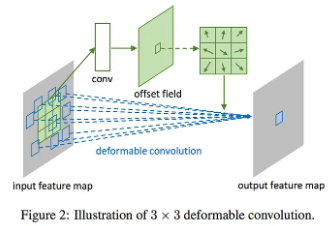

Deformable convolutions add learnable offsets to the standard sampling locations, allowing the grid to shift and adapt to the object shape. This enhances the model’s ability to model objects with a wide range of geometric variations, which is critical for the Flowers102 dataset where the flowers can vary greatly in shape, scale and orientation.

## Imports and Reproducibility Setup

In [1]:
import torch
import torchvision
import torch.nn as nn
from torchvision.ops import DeformConv2d
import torchvision.transforms as transforms
from torchvision.datasets import Flowers102
from torch.utils.data import DataLoader
from torchvision.models import efficientnet_b0
from tqdm import tqdm
import torchvision.models as models
import matplotlib.pyplot as plt
from torchvision import datasets
import numpy as np
from itertools import product
import copy, time
import torch.optim as optim
import random

# For reproducibility
seed = 1001
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
rng = np.random.default_rng(seed)

## Data Preparation and Helper Functions

In [2]:
# Using best config from baseline model
BEST_LR = 5e-4
BEST_BATCH_SIZE = 32
BEST_DROPOUT = 0.3
BEST_WEIGHT_DECAY = 1e-04
BEST_PATIENCE = 5

NUM_CLASSES = 102

In [3]:
# resize images to 224x224 in line with ResNet input size, normalize images so mean and std are in line with pretrained statistics
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
# load the dataset
train_dataset = datasets.Flowers102(root='./data', split='train', download=True, transform=transform)
val_dataset = datasets.Flowers102(root='./data', split='val', download=True, transform=transform)
test_dataset = datasets.Flowers102(root='./data', split='test', download=True, transform=transform)

In [5]:
# create data loaders
# Use tuned batch size from baseline search

train_loader = DataLoader(train_dataset, batch_size=BEST_BATCH_SIZE, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_dataset,   batch_size=BEST_BATCH_SIZE, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset,  batch_size=BEST_BATCH_SIZE, shuffle=False, num_workers=4)

In [6]:
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0.0, verbose=True, model_path='model.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf
        self.verbose = verbose
        self.model_path = model_path

    def early_stop(self, validation_loss, model):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0

            if self.model_path is not None:
                torch.save(model.state_dict(), self.model_path)
            return False

        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1

            if self.counter >= self.patience:
                if self.verbose:
                    print("Early stopping triggered.")
                return True

        return False


In [7]:
class DeformConvBlock(nn.Module):
    """
    Wraps a standard Conv2d into a DeformConv2d + offset conv,
    initialised so that at the start it behaves like the original conv.
    """
    def __init__(self, conv: nn.Conv2d):
        super().__init__()
        k = conv.kernel_size[0]

        self.offset_conv = nn.Conv2d(
            in_channels=conv.in_channels,
            out_channels=2 * k * k,
            kernel_size=k,
            stride=conv.stride,
            padding=conv.padding,
        )

        self.deform = DeformConv2d(
            in_channels=conv.in_channels,
            out_channels=conv.out_channels,
            kernel_size=k,
            stride=conv.stride,
            padding=conv.padding,
            bias=(conv.bias is not None),
        )

        # init: offsets = 0, weights copied from original conv
        with torch.no_grad():
            self.offset_conv.weight.zero_()
            self.offset_conv.bias.zero_()
            self.deform.weight.copy_(conv.weight)
            if conv.bias is not None and self.deform.bias is not None:
                self.deform.bias.copy_(conv.bias)

    def forward(self, x):
        offset = self.offset_conv(x)
        return self.deform(x, offset)


In [8]:
def build_resnet18_baseline():
    try:
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    except:
        model = models.resnet18(pretrained=True)

    in_features = model.fc.in_features
    if BEST_DROPOUT > 0.0:
        model.fc = nn.Sequential(
            nn.Dropout(p=BEST_DROPOUT),
            nn.Linear(in_features, NUM_CLASSES)
        )
    else:
        model.fc = nn.Linear(in_features, NUM_CLASSES)
    return model

def add_deform_to_stem(model):
    model.conv1 = DeformConvBlock(model.conv1)
    return model

def add_deform_to_layer(model, layer_name: str):
    layer = getattr(model, layer_name)
    for block in layer:
        if hasattr(block, "conv1"):
            block.conv1 = DeformConvBlock(block.conv1)
        if hasattr(block, "conv2"):
            block.conv2 = DeformConvBlock(block.conv2)
    return model

def build_variant(variant_name: str):
    model = build_resnet18_baseline()
    if variant_name == "baseline":
        return model
    elif variant_name == "stem":
        return add_deform_to_stem(model)
    elif variant_name in ["layer1", "layer2", "layer3", "layer4"]:
        return add_deform_to_layer(model, variant_name)
    else:
        raise ValueError(f"Unknown variant: {variant_name}")

In [9]:
def plot_loss_and_accuracy(tr_loss, tr_acc, v_loss, v_acc, title_prefix=""):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    ax1.plot(tr_loss, label='Train Loss')
    ax1.plot(v_loss, label='Val Loss')
    ax1.set_title(f'{title_prefix}Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid()

    ax2.plot(tr_acc, label='Train Acc')
    ax2.plot(v_acc, label='Val Acc')
    ax2.set_title(f'{title_prefix}Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid()

    plt.tight_layout()
    plt.show()


In [10]:
criterion = nn.CrossEntropyLoss()

def train_deform_variant(
    variant_name,
    lr=BEST_LR,
    weight_decay=BEST_WEIGHT_DECAY,
    max_epochs=30,
    patience=BEST_PATIENCE
):
    """
    Train one ResNet18 deformable variant.

    Selection rule:
      - Track best checkpoint by validation accuracy (primary),
        and validation loss (secondary for tie / strong improvement).
      - Return Test Acc evaluated using that best checkpoint.
    """

    # Fresh model for this variant
    model = build_variant(variant_name)

    optimizer = optim.Adam(
        model.parameters(),
        lr=lr,
        weight_decay=weight_decay
    )

    best_val_acc = 0.0
    best_val_loss = float("inf")
    best_model_state = None
    epochs_no_improve = 0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(1, max_epochs + 1):
        # ---------- Train ----------
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for X, y in train_loader:

            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            bs = y.size(0)
            running_loss += loss.item() * bs
            preds = outputs.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += bs

        train_loss = running_loss / max(total, 1)
        train_acc = correct / max(total, 1)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # ---------- Validation ----------
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for X, y in val_loader:

                outputs = model(X)
                loss = criterion(outputs, y)

                bs = y.size(0)
                val_running_loss += loss.item() * bs
                preds = outputs.argmax(dim=1)
                val_correct += (preds == y).sum().item()
                val_total += bs

        val_loss = val_running_loss / max(val_total, 1)
        val_acc = val_correct / max(val_total, 1)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(
            f"[{variant_name}] Epoch {epoch} | Train Loss={train_loss:.4f} | Train Acc={train_acc:.4f} | Val Loss={val_loss:.4f} | Val Acc={val_acc:.4f}"
        )

        # ---------- Track best checkpoint ----------
        improved = False

        if val_acc > best_val_acc:
            improved = True
        elif abs(val_acc - best_val_acc) < 1e-8 and val_loss < best_val_loss - 1e-6:
            improved = True
        elif val_loss < best_val_loss - 1e-6:
            # strong val loss improvement can also update
            improved = True

        if improved:
            best_val_acc = val_acc
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # ---------- Early stopping ----------
        if epochs_no_improve >= patience:
            print(f"[{variant_name}] Early stopping at epoch {epoch}")
            break

    epochs_ran = epoch
    print(f"[{variant_name}] | Best Val Acc={best_val_acc:.4f}")

    # ---------- Evaluate on test with best checkpoint ----------
    if best_model_state is None:
        best_model_state = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_state) 

    model.eval()

    test_correct = 0
    test_total = 0
    test_running_loss = 0.0

    with torch.no_grad():
        for X, y in test_loader:

            outputs = model(X)
            loss = criterion(outputs, y)

            bs = y.size(0)
            test_running_loss += loss.item() * bs
            preds = outputs.argmax(dim=1)
            test_correct += (preds == y).sum().item()
            test_total += bs

    test_loss = test_running_loss / max(test_total, 1)
    test_acc = test_correct / max(test_total, 1)

    print(
        f"[{variant_name}] Test Loss={test_loss:.4f} | "
        f"Test Acc ={test_acc:.4f}"
    )

    history = {
        "tr_loss": train_losses,
        "tr_acc": train_accuracies,
        "v_loss": val_losses,
        "v_acc": val_accuracies,
    }

    return best_val_acc, test_acc, history, epochs_ran, best_model_state


## Training Loop
Building on the final baseline model for ResNet18, we implemented a few variants, replacing specific Conv2d layers with DeformConv2d and leaving the remaining layers unchanged. The five experiments include replacing the first convolutional layer in the stem, and the convolutional layers in ResNet18’s Stages 1 to 4 respectively.

Here are the variants tested:
| Stages Replaced       | 
|-----------------|
| Stem    | 
| Stage 1 | 
| Stage 2 | 
| Stage 3 | 
| Stage 4 | 

In [11]:
variant_names = ["stem", "layer1", "layer2", "layer3", "layer4"]

histories = {}
results = {}

best_variant = None
best_val_acc_overall = -1.0
best_model_state_overall = None

for name in variant_names:
    print("\n" + "="*70)
    print(f"Training variant: {name}")

    best_val_acc, test_acc, history, epochs_ran, state = train_deform_variant(
        variant_name=name,
        lr=BEST_LR,
        weight_decay=BEST_WEIGHT_DECAY,
        max_epochs=30,
        patience=BEST_PATIENCE
    )

    histories[name] = history
    results[name] = {
        "best_val_acc": best_val_acc,
        "test_acc": test_acc,
        "epochs_ran": epochs_ran,
        "state_dict": state
    }

    if best_val_acc > best_val_acc_overall:
        best_val_acc_overall = best_val_acc
        best_variant = name
        best_model_state_overall = state

print("\n" + "="*70)
print("Summary: Best Val / Test per variant")
for name in variant_names:
    print(
        f"{name:8s} | "
        f"Best Val Acc={results[name]['best_val_acc']:.4f} | "
        f"Test Acc={results[name]['test_acc']:.4f}"
    )

print(f"\nBest variant overall by Val Acc: {best_variant} "
      f"(Best Val Acc={best_val_acc_overall:.4f}, "
      f"Test Acc={results[best_variant]['test_acc']:.4f})")


Training variant: stem
[stem] Epoch 1 | Train Loss=3.6349 | Train Acc=0.2510 | Val Loss=2.1325 | Val Acc=0.5000
[stem] Epoch 2 | Train Loss=1.2413 | Train Acc=0.8382 | Val Loss=1.3614 | Val Acc=0.7725
[stem] Epoch 3 | Train Loss=0.3327 | Train Acc=0.9765 | Val Loss=0.9416 | Val Acc=0.8206
[stem] Epoch 4 | Train Loss=0.0978 | Train Acc=0.9980 | Val Loss=0.7778 | Val Acc=0.8627
[stem] Epoch 5 | Train Loss=0.0459 | Train Acc=1.0000 | Val Loss=0.6695 | Val Acc=0.8716
[stem] Epoch 6 | Train Loss=0.0235 | Train Acc=1.0000 | Val Loss=0.6347 | Val Acc=0.8784
[stem] Epoch 7 | Train Loss=0.0168 | Train Acc=1.0000 | Val Loss=0.6283 | Val Acc=0.8833
[stem] Epoch 8 | Train Loss=0.0122 | Train Acc=1.0000 | Val Loss=0.5852 | Val Acc=0.8843
[stem] Epoch 9 | Train Loss=0.0101 | Train Acc=1.0000 | Val Loss=0.5845 | Val Acc=0.8980
[stem] Epoch 10 | Train Loss=0.0081 | Train Acc=1.0000 | Val Loss=0.5648 | Val Acc=0.8990
[stem] Epoch 11 | Train Loss=0.0086 | Train Acc=1.0000 | Val Loss=0.5701 | Val Acc=0.

## Data Visualisation and Plots

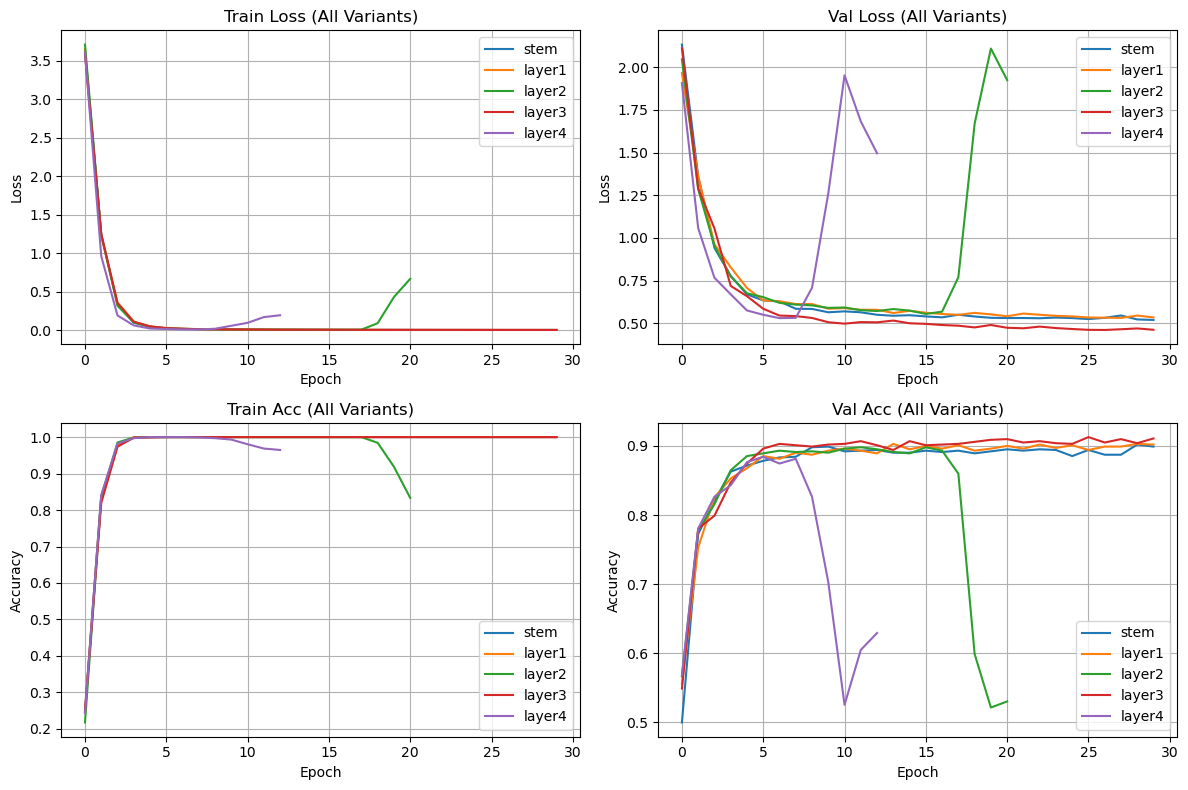

In [12]:
def plot_all_histories(histories_dict):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    ax_tr_loss, ax_v_loss, ax_tr_acc, ax_v_acc = axes[0,0], axes[0,1], axes[1,0], axes[1,1]

    for name, h in histories_dict.items():
        ax_tr_loss.plot(h["tr_loss"], label=name)
        ax_v_loss.plot(h["v_loss"], label=name)
        ax_tr_acc.plot(h["tr_acc"], label=name)
        ax_v_acc.plot(h["v_acc"], label=name)

    ax_tr_loss.set_title("Train Loss (All Variants)")
    ax_tr_loss.set_xlabel("Epoch")
    ax_tr_loss.set_ylabel("Loss")
    ax_tr_loss.grid()
    ax_tr_loss.legend()

    ax_v_loss.set_title("Val Loss (All Variants)")
    ax_v_loss.set_xlabel("Epoch")
    ax_v_loss.set_ylabel("Loss")
    ax_v_loss.grid()
    ax_v_loss.legend()

    ax_tr_acc.set_title("Train Acc (All Variants)")
    ax_tr_acc.set_xlabel("Epoch")
    ax_tr_acc.set_ylabel("Accuracy")
    ax_tr_acc.grid()
    ax_tr_acc.legend()

    ax_v_acc.set_title("Val Acc (All Variants)")
    ax_v_acc.set_xlabel("Epoch")
    ax_v_acc.set_ylabel("Accuracy")
    ax_v_acc.grid()
    ax_v_acc.legend()

    plt.tight_layout()
    plt.show()

plot_all_histories(histories)



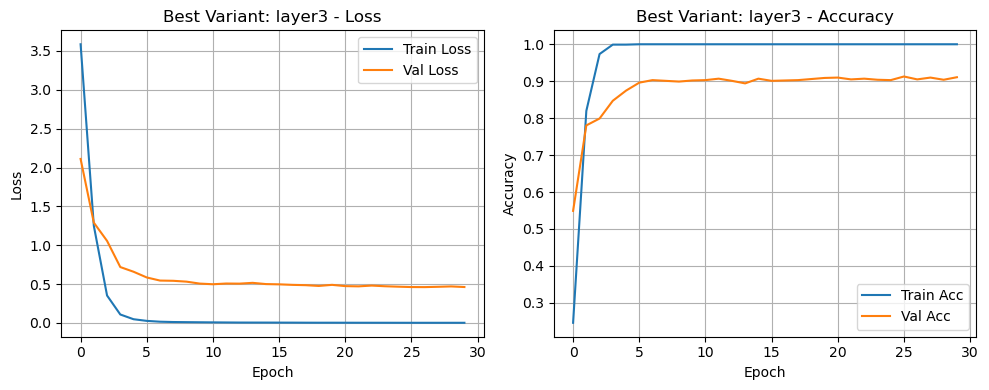

In [13]:
best_hist = histories[best_variant]
plot_loss_and_accuracy(
    best_hist["tr_loss"],
    best_hist["tr_acc"],
    best_hist["v_loss"],
    best_hist["v_acc"],
    title_prefix=f"Best Variant: {best_variant} - "
)